***Film özelliklerine göre ruh hali sınıflandırması***

**Kullanıcının ruh haline uygun film önerileri yapılabilmesi için her filmin metinsel içeriğine dayanarak `mod` (örneğin: mutlu, üzgün, heyecanlı) etiketinin tahmin edilmesi hedeflenmiştir.**

İlk olarak gerekli kütüphaneleri import ederek başlıyoruz.

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [215]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score


Kaggle üzerinde indirdiğimiz csv dosyasını yükleyip ön işleme işlemi gerçekleştiriyoruz.

In [216]:
df = pd.read_csv("/kaggle/input/movies/movies.csv")

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4792 entries, 0 to 4791
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4792 non-null   int64  
 1   budget                4792 non-null   int64  
 2   genres                4767 non-null   object 
 3   homepage              1710 non-null   object 
 4   id                    4792 non-null   int64  
 5   keywords              4384 non-null   object 
 6   original_language     4792 non-null   object 
 7   original_title        4792 non-null   object 
 8   overview              4789 non-null   object 
 9   popularity            4792 non-null   float64
 10  production_companies  4792 non-null   object 
 11  production_countries  4792 non-null   object 
 12  release_date          4791 non-null   object 
 13  revenue               4792 non-null   int64  
 14  runtime               4790 non-null   float64
 15  spoken_languages     

veri kümemiz 4792 satır ve 25 stündan oluşuyor. overview, genres, tagline ve keywords özelliklerini kullanrak mod özelliğini tahmin etmeye çalışıyoruz.

csv dosyasındaki eksik verilerin yerlerini true/false olarak gösteriyoruz. 

In [218]:
missing_value = df.isnull()
print("Eksik değer olan hücreler:\n", missing_value)

Eksik değer olan hücreler:
       index  budget  genres  homepage     id  keywords  original_language  \
0     False   False   False     False  False     False              False   
1     False   False   False     False  False     False              False   
2     False   False   False     False  False     False              False   
3     False   False   False     False  False     False              False   
4     False   False   False     False  False     False              False   
...     ...     ...     ...       ...    ...       ...                ...   
4787  False   False   False      True  False     False              False   
4788  False   False   False      True  False     False              False   
4789  False   False   False      True  False     False              False   
4790  False   False   False      True  False      True              False   
4791  False   False   False     False  False     False              False   

      original_title  overview  popularity  ...

csv dosyamızda bazı verilerin moodlarını etiketledik. Bu sayede de gözetimli öğrenme kullanarak makinenin diğer filmler için mod tahmin etmesini sağlayacağız. İlk olarak sadece modları etiketlediğimiz verileri alıyoruz ve f string kullanarak kaç tane etiketlenmiş veri olduğunu gösteriyoruz.

In [219]:
df_labeled = df[df['mod'].notnull()].copy()
print(f"Etiketli film sayısı: {len(df_labeled)}")

Etiketli film sayısı: 603


Modelin sınıflandırma yeteneğini düşürmemek için en az 2 örneğe sahip sınıfları alıyoruz.

In [220]:
class_counts = df_labeled["mod"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_labeled = df_labeled[df_labeled["mod"].isin(valid_classes)]

overview, genres, tagline, keywords gibi stünları birleştirerek tek bir metin alanı oluşturuyoruz.

In [221]:
text_cols = ["overview", "genres", "tagline", "keywords"]
for col in text_cols:
    df_labeled[col] = df_labeled[col].fillna("")

df_labeled["text"] = (
    df_labeled["overview"] + " " +
    df_labeled["genres"] + " " +
    df_labeled["tagline"] + " " +
    df_labeled["keywords"]
)

veri setimiz %80 eğitim ve %20 test olarak bölündü. Bu bölünme ise stratified olarak yani dengeli olacak şekilde bölündü. x özelliklerimiz bağımsız değişkenlerdir, y ise hedef değişken yani bağımlı değişkendir. train_test_split() methodu veriyi eğitim ve test veri setine bölüyor.

In [222]:

X = df_labeled["text"]
y = df_labeled["mod"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Naive Bayes, Lojistik Regresyon ve Linear SVC Modelleri bu modelleri kullanarak model performans karşılaştırması yapıyoruz.
TF-IDF + Sınıflandırıcı şeklinde bir pipeline oluşturularak `cross_val_score` ile modeller karşılaştırılır.

In [223]:

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC(class_weight="balanced")
}

results = {}


for name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_df=0.9)),
        ("clf", model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    results[name] = scores
    print(f"{name} CV Accuracy: {np.mean(scores):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Naive Bayes CV Accuracy: 0.5750


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression CV Accuracy: 0.6167


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Linear SVC CV Accuracy: 0.7083


GridSearch ile En İyi LinearSVC Modelini Seçme işlemi gerçekleştiriyoruz.

In [224]:
pipeline_svc = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC(class_weight="balanced"))
])

param_grid = {
    "tfidf__max_df": [0.7, 0.85, 1.0],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__C": [0.1, 1, 10]
}

grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest parameters:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Best parameters: {'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
Best CV accuracy: 0.7146


en iyi model ile (SVC) tahmin yürütülerek sınıflandırma raporu ve doğruluk oranını hesaplıyoruz.

In [225]:
y_pred = grid.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))



Classification Report:
                precision    recall  f1-score   support

      depresif       0.00      0.00      0.00         1
     eglenceli       0.57      0.71      0.63        28
        gergin       0.75      0.88      0.81        69
     hareketli       0.00      0.00      0.00         1
       huzunlu       0.00      0.00      0.00         2
       huzurlu       0.00      0.00      0.00         2
      maceraci       0.00      0.00      0.00         1
        neseli       0.00      0.00      0.00         3
ortaya karisik       0.00      0.00      0.00         2
         sakin       0.75      0.27      0.40        11

      accuracy                           0.70       120
     macro avg       0.21      0.19      0.18       120
  weighted avg       0.64      0.70      0.65       120

Accuracy: 0.7


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix göreselleştirme işlemi gerçekleştiriyoruz. Gerçek etiketler (y_test) ile modelin tahmin ettiği etiketler (y_pred) karşılaştırılır.

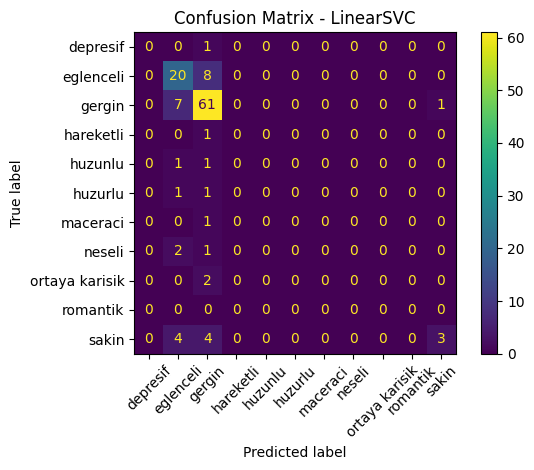

In [226]:
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - LinearSVC")
plt.tight_layout()
plt.show()


***Confusion matrisimize baktığımızda en çok doğruluk oranının gergin moodunda olduğunu görüyoruz. Diğer moodların doğruluk oranının düşük olmasının sebebi ise etiketlediğimiz verilerin sayısının az olması bu sorun ise daha fazla veri çeşitliliği etiketlenerek hata payı azaltılabilir.***

kullandığımız modellerin karşılaştırma sonuçlarını görselleştiriyoruz

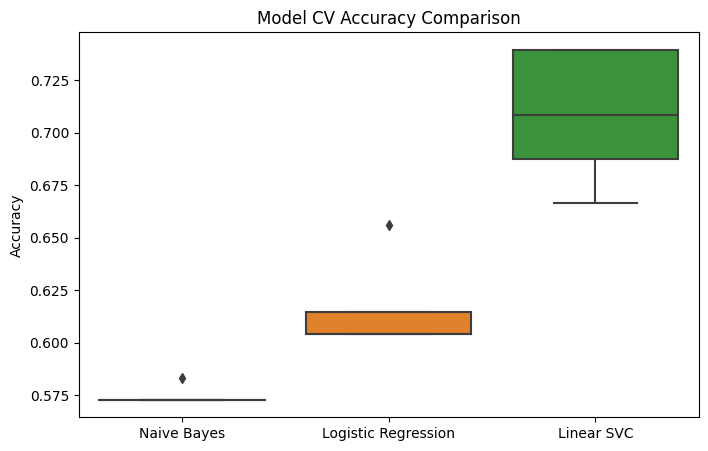

In [227]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(results))
plt.title("Model CV Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

Bu grafiğe baktığımızda modellerin boxplot yani kutu grafiklerini görüyoruz. En yüksek başarı oranına sahip model Linear SVC olduğunu görüyoruz hatta bazı kısımlarda doğruluk oranı %73'e kadar çıkabiliyor. Logistic Regression orta seviyede bir başarı sağlıyor.Naive Bayers ise bu veri setimiz için çok düşük bir başarı sağlıyor.